## Intro

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RERUN = False

The main purpose of this doc, is trying to determine the right number of topics for our corpus (currently handling only nonbib, hebrew texts).
Ive sucseeded to lemmatize the text with the [dictabert-lex](https://huggingface.co/dicta-il/dictabert-lex) model which attempts to match up each word with the correct lexeme from within the BERT vocabulary.
This doc structure is as follows:
1. What are the problems in the current research for dealing with the problem of choosing the right number of topics.
2. Some additional pre-processing to the corpus.
3. Choosing number of topics:
    1. Running multiple LDA models with a different number of optional topics and plot varoius metrics.
    2. Running hierarchical dirichlet process for inferring number of topics.
    3. Hyper parameter tuning for best number of topics.
4. Short analysis of the topics after selecting (probably) the right number of topics. Chosen number of topics = 18-19 (regular text 18, lemmatized 19)



TODO: 
1. Implement more models (BertTopic, LSA, etc).

## Data

In [3]:


DATA_PATH = "data/filtered_text_and_starr_features_22_05_2024.csv"
df = pd.read_csv(DATA_PATH)
df_grouped = df.groupby("book")["text"].apply(' '.join).reset_index()
book_info = df[["book", "composition", "section", "text_lex"]].drop_duplicates()
df_by_book = pd.merge(df_grouped, book_info, on="book", how="inner").drop_duplicates(["book"])


df_by_book


,book,text,composition,section,text_lex
0,11Q1,וסמכ ידו על ראש השעיר ושחט אתו במקומ אשר ישחט...,Lev,NaN,סמך יד ראש עיר שחט את מקום שחט עלה פנה יהוה חט...
20,11Q11,וה כב הא ם ע דם סוכות לם ו ה ת יך ב את שבעים ...,NaN,NaN,וה כב א ם ע דם סוכ לם ה יך ב שבעים ל מים אחד ת...
27,11Q12,הודענו בצאתנו לפני יהוה אלוהינו את כול החטאות...,Book_of_Jubilees,non_sectarian_texts,ידע יצא פנה יהוה אלהים כל חטאת עה שמים ארץ אור...
32,11Q13,שון מושה כיא ש מ על ל ואשר אמר בשנת היובל הזו...,NaN,NaN,שון משה ש מ על ל אמר שנה יובל זה שוב איש אחזה ...
38,11Q17,ים מ האור מ סדרותיו סדרותיו מבנית שי קודש ישמ...,NaN,NaN,מ אור מ דרה דרה מבנית ש קדש שמע תהלה אלהים מ א...
...,...,...,...,...,...
2970,Sdeir1,אשר סביבתיהם ולא רדפו אחרי בני יעקב ויבא יעקב ...,NaN,NaN,סביב רדף בן יעקב בוא יעקב לוז ארץ כנען היא בית...
2974,Xhev/se5,וידבר יהוה אל משה לאמר קדש לי כל בכור בבני ישר...,NaN,NaN,דבר יהוה משה אמר קדש ל כל בכר בן יראל אדם ב ב ...
2979,Xq1,ויאמר יהוה אל משה ואהרן זאת חקת הפסח כל בן נכר...,NaN,NaN,אמר יהוה משה אהרן זה חקה פסח כל בן נכר אכל ב כ...
2983,Xq2,את הדברים האלה דבר יהוה עם כל קהלכם בהר מתוך ה...,NaN,NaN,דבר אלה דבר יהוה כל קהל הר תוך אש חשך ענן ערפל...


## Topic modeling

### Choosing the right number of topics

When performing topic modeling with LDA, one of the parameters that we need to provide is the number of topics we wish to get as the result.
This problem is a bit challenging because of the following reasons:
1. Subjective Interpretations: The determination of what constitutes a coherent topic is subjective and varies between users. This variability makes it difficult to establish a universally optimal number of topics that satisfy all interpretations and use cases.
Reference: Chang, J., Boyd-Graber, J., Gerrish, S., Wang, C., & Blei, D. M. (2009). [Reading Tea Leaves: How Humans Interpret Topic Models](https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf)

2. Corpus Characteristics: The diversity and dimensions of the dataset—such as document length, the breadth of vocabulary, and the granularity of content—play a critical role in influencing the appropriate number of topics. Different corpora may naturally support different numbers of distinct themes.
Reference: Greene, D., O'Callaghan, D., & Cunningham, P. (2014). [How Many Topics? Stability Analysis for Topic Models](https://arxiv.org/pdf/1404.4606)

3. Absence of Ground Truth: In unsupervised learning, like topic modeling, there is no clear benchmark or ground truth for validating the chosen number of topics. This absence makes it challenging to objectively evaluate the accuracy and relevance of the model's output.
Reference: [On finding the natural number of topics with latent dirichlet allocation: Some observations](https://link.springer.com/chapter/10.1007/978-3-642-13657-3_43)


4. Sensitivity to Model Specifications: The chosen number of topics can be sensitive to slight variations in model parameters or the data preprocessing steps. This sensitivity often results in different models suggesting different numbers of topics for the same dataset, complicating the selection process.
Reference: Lau, J. H., Newman, D., & Baldwin, T. (2014). [Machine reading tea leaves: Automatically evaluating topic coherence and topic model quality](https://aclanthology.org/E14-1056/)


As for today, the main metrics for choosing the number of topics are:

1. Coherence Measures: Coherence scores, such as C_V, UMass, C_UCI, and C_NPMI, are widely used because they offer a quantitative way to assess the semantic coherence of the topics produced by the model. These measures evaluate how meaningfully the top words in each topic relate to each other, with higher scores generally indicating better topics. (Appendix below)
Reference: Röder, M., Both, A., & Hinneburg, A. (2015). [Exploring the space of topic coherence measures](https://dl.acm.org/doi/10.1145/2684822.2685324)

2. Perplexity: Perplexity is a statistical measure of how well a probability model predicts a sample. In topic modeling, lower perplexity is typically associated with a model that can better predict unseen documents, although it does not necessarily correlate with human interpretability of the topics.
Reference: Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). [Latent dirichlet allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
$$
\text{perplexity}({D_{test}}) = \exp\left\{-\frac{\sum_{d=1}^{M} \log p(w_d)}{\sum_{d=1}^{M} N_d}\right\}
$$


3. Stability Analysis (didn't implement it in this doc): Stability analysis involves measuring how consistent the topics are across different runs of the model, with varying parameters or subsamples of the data. Consistent topics across multiple tests can indicate that the model has found a meaningful structure in the data.
Reference: Mimno, D., Wallach, H. M., Talley, E., Leenders, M., & McCallum, A. (2011). [Optimizing semantic coherence in topic models](https://aclanthology.org/D11-1024/)

4. Human Judgment: Ultimately, qualitative evaluation by subject matter experts is often used in conjunction with quantitative methods. Experts assess the meaningfulness and utility of the topics within the context of specific research or business objectives.
Reference: Chang, J., Boyd-Graber, J., Gerrish, S., Wang, C., & Blei, D. M. (2009). [Reading Tea Leaves: How Humans Interpret Topic Models](https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf)


* Another interesting way is to use [Hierarchical Dirichlet Processes](https://people.eecs.berkeley.edu/~jordan/papers/hdp.pdf) which can infer what is the optimal number of topics (the problem is selecting the right parameters). Implemented at the end of this doc.
* There are also a few papers that tried to use some new metrics (combining a few metrics together) like in [Selection of the Optimal Number of Topics for LDA Topic Model—Taking Patent Policy Analysis as an Example](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8534395/), [A heuristic approach to determine an appropriate number of topics in topic modeling](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-16-S13-S8) 



In [4]:
import gensim
from gensim import corpora
import tomotopy as tp
import pandas as pd
from scipy.spatial import distance
from datetime import datetime
from collections import Counter

# Functions related to word frequency analysis
def get_top_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common(n)]


def get_bottom_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common()[:-n - 1:-1]]


def remove_words_from_text(texts, words_to_remove):
    new_texts = []
    for text in texts:
        new_texts.append([word for word in text if word not in words_to_remove])
    return new_texts


def bigram_per_prcosessing(texts, min_count_bigram, threshold_bigram):
    bigram = gensim.models.Phrases(texts, min_count=min_count_bigram, threshold=threshold_bigram)
    texts = [bigram[text] for text in texts]
    return texts


def common_non_common_words_removal(texts, top_words_removal, bottom_words_removal):
    most_common_words = get_top_n_words(texts, top_words_removal)
    texts = remove_words_from_text(texts, most_common_words)
    least_common_words = get_bottom_n_words(texts, bottom_words_removal)
    texts = remove_words_from_text(texts, least_common_words)

    print(f"Removed {most_common_words=}, {least_common_words=} from text")
    return texts


def generate_components(df, column, min_count_bigram, threshold_bigram, top_words_removal,
                        bottom_words_removal, words_removal=True, bigram_process=True):
    texts = [[word for word in str(doc).split(" ")] for doc in df[column]]
    if bigram_process:
        texts = bigram_per_prcosessing(texts, min_count_bigram, threshold_bigram)
    if words_removal:
        texts = common_non_common_words_removal(texts, top_words_removal, bottom_words_removal)
    return texts


In [5]:
texts = generate_components(df_by_book,"text_lex",min_count_bigram=1, threshold_bigram=4, top_words_removal=8, bottom_words_removal=10, words_removal=True,
                                                         bigram_process=False)

texts = [" ".join(doc) for doc in texts]


Removed most_common_words=['כל', 'ל', 'יהוה', 'יום', 'אמר', '', 'ב', 'אלהים'], least_common_words=['כיר', 'תושב', 'רחל', 'בכות', 'ינק', 'לוז', 'חזיון', 'צחנה', 'באש', 'קדמני'] from text


In [6]:
len(texts)

202

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts).toarray()
with open('data_all_scrolls_lex.npy', 'wb') as f:
    np.save(f, X)
X.shape



(202, 1868)

10
4


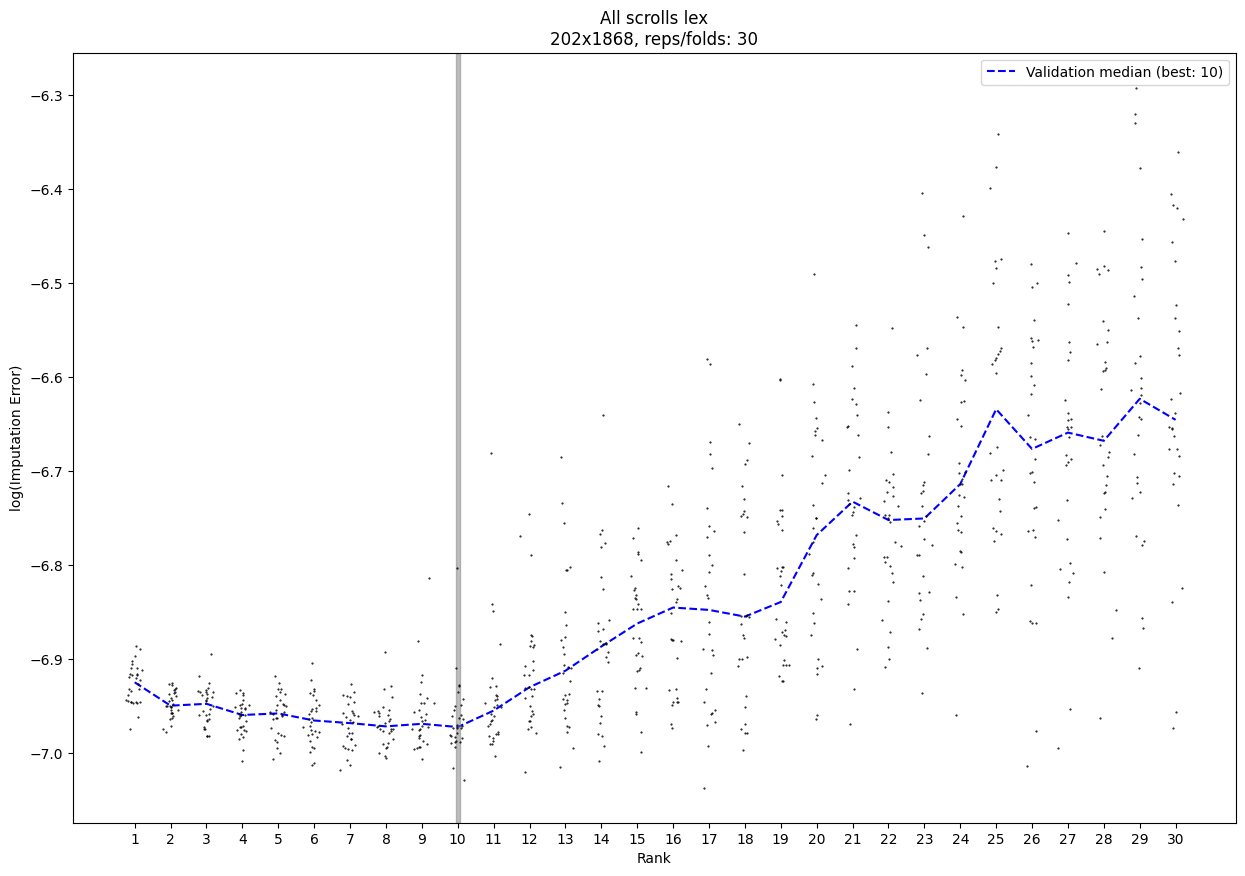

In [7]:
from config import BASE_DIR

errors = np.load(f"{BASE_DIR}/notebooks/data/errors_all_lex_reps-30_obj-jk_frac-0.1_k-1_30_max_iter-2000.npy")
Ks = list(range(1,30+1))

def produce_figure(errors, rollback=False):
    """
    produces a figure that shows the results
    :param rollback: int - chosen k, after rolling backwards from the k with minimum median error
    """
    
    medians = np.nanmedian(errors, axis=1)
    fig, ax = plt.subplots(figsize=(15,10))
    title_str = "All scrolls lex" + "\n%dx%d, reps/folds: %d" % (202, 1868, 30)
    plt.title(title_str)
    plt.xlabel('Rank')
    plt.ylabel('log(Imputation Error)')
    rank_cycle = np.array([[i] * 30 for i in Ks]).flatten()
    plt.plot(rank_cycle + np.random.randn(rank_cycle.size) * .1, np.log(errors.flatten()), '.k', markersize=1)  # scatter
    plt.plot(Ks, np.log(medians), 'b--', zorder=-1, label='Validation median (best: %d)' % best_k)
    plt.legend(loc='best')
    plt.xticks(Ks)
    
    if rollback:
        plt.axvspan(best_k_after_rollback - 0.05, best_k_after_rollback + 0.05, color='gray', alpha=0.5)
    else:
        plt.axvspan(best_k - 0.05, best_k + 0.05, color='gray', alpha=0.5)

    plt.show()
import scipy
def rollback(errors):
    """
    Finds K after rolling backwards from the k with minimum median value, using Wilcoxon rank-sum test
    :param errors: numpy array of errors (Ks x repetitions)
    :return: index of K after rollback
    """
    best_k_arg = np.argmin(np.nanmedian(errors, axis=1))
    # rollback
    for k in range(best_k_arg):
        best_k_runs = errors[best_k_arg]
        next_k_runs = errors[k]
        u, p = scipy.stats.ranksums(next_k_runs, best_k_runs)
        if p > 0.05:
            best_k_arg = k
            break
    return best_k_arg
best_k_arg = np.argmin(np.nanmedian(errors, axis=1))
best_k = Ks[best_k_arg]
# rollback
best_k_after_rollback_idx = rollback(errors)
best_k_after_rollback = Ks[best_k_after_rollback_idx]
print(best_k)
print(best_k_after_rollback)
produce_figure(errors)

In [68]:
# Fit final NMF model with the optimal number of topics
model = NMF(n_components=10, init='random', random_state=0, max_iter=4500)
W_final = final_model.fit_transform(X)
H_final = final_model.components_

# Display the top words in each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H_final):
    print(f"Topic #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-25 - 1:-1]]))


Topic #0:
קול שמע דבר אש תוך הר אל חיה ראה גדול יסף זה לוח אבן מי מות ענן כמו כתב קרב היה בער ערפל מראה אדם
Topic #1:
שבת ערים דוק ער ארבע שנים חמש שלש שש אחד שני חדש מאה שנה תשע שלישי שלשים בוא מים שבע ראשון שמנה ערה עשתי ידעיה
Topic #2:
בר שנה קרה הוה חזה אנה ארע משתו שמין דן ברה עובד עבד מלך חד קבל שביע תלתין אנש מלה חזו תרע דר אנתה אח
Topic #3:
אכל זה חמץ יצא שבע מצה חדש משה ראה עבד זוב אר בכר אביב פטר חוי חתי יבוסי כנעני דבש אמרי אתם חג רחם ארץ
Topic #4:
אמת מעה אל איש עולם פה שוב קץ לב יחד יד ברית רוח דרך ספר צבא ידע בן בליעל משפט פחד שפט עה אתה כלה
Topic #5:
קרב מזבח כהן קרבן בן חלב עלה דם אהרן שחט מועד אהל את קטר חטאת סמך איל פתח נתח שלם פנה בקר ראש אשה יד
Topic #6:
ארץ את לבב נתן שמים עה אהב עם אדון פנה דרך הלך ירא עין מן טוב עבר שמר אב נא ירש אל אדמה גוי אכל
Topic #7:
שבע פלא רום קדש עולם קדוש ברך ניא תהלה ראש סוד כבוד דבר הלל צדק הוד לשון מקור ידע קורב זמר כהנה דרה גבורה גדל
Topic #8:
בן יעקב היה מצרים יראל ילד בוא פרעה שם מלך משה עם יוסף קרא בת אח הוא יהודה ארץ אל בית אשה י

In [63]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from scipy.stats import wilcoxon
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm



# Vectorize the text data
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char')

X = vectorizer.fit_transform(texts).toarray()

def nmf_with_imputation(X, K, p):
    # Randomly mask a fraction p of the entries in X
    mask = np.random.rand(*X.shape) > p
    X_masked = X * mask
    
    # Fit NMF
    model = NMF(n_components=K, init='random', random_state=0, max_iter=1000)
    W = model.fit_transform(X_masked)
    H = model.components_
    
    # Impute missing values
    X_imputed = np.dot(W, H)
    return X_imputed, mask
from scipy.special import kl_div
def cross_validate_nmf(X, K_values, p, T):
    errors = {K: [] for K in K_values}
    
    for K in tqdm(K_values):
        for t in range(T):
            X_imputed, mask = nmf_with_imputation(X, K, p)
            original = X[mask == 0]
            imputed = X_imputed[mask == 0]
            error = mean_squared_error(original, imputed)
            errors[K].append(error)
    
    return errors

# def determine_optimal_K(scores, median_errors):
#     K_values = list(median_errors.keys())
#     K_star = min(median_errors, key=median_errors.get)
#     
#     for K in K_values:
#         if K >= K_star:
#             continue
#         _, p_value = wilcoxon(scores[K], scores[K_star])
#         if p_value > 0.05:
#             K_star = K
#     
#     return K_star
from scipy.stats import ranksums
def rollback(errors):
    median_errors = {K: np.nanmedian(errors[K]) for K in errors.keys()}
    best_k_arg = min(median_errors, key=median_errors.get)
    best_k_arg_index = list(errors.keys()).index(best_k_arg)
    
    for i, K in enumerate(errors.keys()):
        if i >= best_k_arg_index:
            continue
        _, p = ranksums(errors[K], errors[best_k_arg])
        if p > 0.05:
            best_k_arg = K
            break
    return best_k_arg

# Define parameters
K_values = list(range(2, 30,1))
p = 0.1
T = 30

# Run cross-validation
# scores, median_errors = cross_validate_nmf(X, K_values, p, T)
# optimal_K = determine_optimal_K(scores, median_errors)

# Run cross-validation
errors = cross_validate_nmf(X, K_values, p, T)
optimal_K_index = rollback(errors)-1
optimal_K = K_values[optimal_K_index]
print(f"The optimal number of topics is: {optimal_K}")


In [64]:

import random

error_points = []
for k, tmp_lst in errors.items():
    for sc in tmp_lst:
        error_points.append((k,sc))
median_errors = {K: np.nanmedian(errors[K]) for K in errors.keys()}
log_med_errors = np.log(np.array(list(median_errors.values())))

plt.figure(figsize=(10, 6))
plt.plot(list(median_errors.keys()), log_med_errors, marker='o')
plt.scatter([i[0]+random.random()*0.1 for i in error_points], [(np.log(i[1])) for i in error_points], s=0.4)
plt.xlabel('Number of Topics (K)')
plt.ylabel('Median Reconstruction Error')
plt.title('Median Reconstruction Error for Different Values of K')
# plt.ylim([0.000450, 0.000525])
plt.axvline(x=optimal_K, color='r', linestyle='--')
plt.show()

#### Selecting number of topics with Hierarchical Dirichlet Processes

The Hierarchical Dirichlet Process (HDP) is an advanced Bayesian model that is particularly useful for problems where you need to infer the number of underlying groups or patterns in data without specifying the number in advance. It extends the Dirichlet Process (DP) by linking multiple DPs through a shared base distribution, allowing for a hierarchy of groups that can share statistical strength.

In the context of topic modeling, the HDP is advantageous because it can automatically determine the number of topics present in a collection of documents.

[Hierarchical Dirichlet process](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process)

In [7]:
import tomotopy as tp
from gensim.models import CoherenceModel


def plot_hdp_res(hdp_res):
    means = hdp_res.reset_index().groupby("num_topics")[['loglik', 'perplexity', 'coherence']].mean()
    stds = hdp_res.reset_index().groupby("num_topics")[['loglik', 'perplexity', 'coherence']].std().fillna(0)

    lower_bound = means - stds
    upper_bound = means + stds

    fig, ax1 = plt.subplots()

    # Plot for perplexity
    ax1.fill_between(means.index, lower_bound['perplexity'], upper_bound['perplexity'], alpha=.3)
    ax1.plot(means.index, means['perplexity'], label='Perplexity', color='b')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Perplexity', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.fill_between(means.index, lower_bound['coherence'], upper_bound['coherence'], alpha=.3, color='red')
    ax2.plot(means.index, means['coherence'], label='Coherence', color='red')
    ax2.set_ylabel('Coherence', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title("Score of Perplexity and Coherence")
    fig.tight_layout()  # Adjust layout to prevent overlap

    plt.show()


def train_evaluate_hdp(gamma, alpha, eta, texts, iter_range=range(0, 1000, 100)):
    term_weight = tp.TermWeight.ONE
    hdp = tp.HDPModel(tw=term_weight, gamma=gamma, alpha=alpha, eta=eta,
                      initial_k=2, seed=42)

    # Add docs to train
    for vec in texts:
        hdp.add_doc(vec)

    # Initiate sampling burn-in
    hdp.burn_in = 100
    hdp.train(0)
    hdp_results = []

    # Train model
    for i in iter_range:
        hdp.train(100, show_progress=False)  # 100 iterations at a time
        # topics_d = get_hdp_topics(hdp, top_n=10)
        coherence_score = tp.coherence.Coherence(hdp, coherence='c_v').get_score()
        hdp_results.append((i, hdp.ll_per_word, hdp.live_k, hdp.perplexity, coherence_score, gamma, alpha, eta))
        print(
            f"{datetime.now()}---{i=}, {hdp.ll_per_word=}, {hdp.live_k=}, {hdp.perplexity=}, {coherence_score=}, {gamma=}, {alpha=}, {eta=}")

    return hdp_results


In [8]:
if RERUN:
    gammas = [0.01, 0.1, 0.5, 0.99]
    alphas = [0.01, 0.1, 0.5, 0.99]
    etas = [0.005, 0.01, 0.1, 0.5, 0.99]

    # List to store all results
    all_results = []

    # Loop over all combinations of gamma, alpha, and eta
    for gamma in gammas:
        for alpha in alphas:
            for eta in etas:
                print(f'Training with gamma={gamma}, alpha={alpha}, eta={eta}')
                results = train_evaluate_hdp(gamma, alpha, eta, texts, range(0, 1000, 100))
                all_results.extend(results)

    # Create DataFrame with all results
    columns = ["iter", "loglik", "num_topics", "perplexity", "coherence", "gamma", "alpha", "eta"]
    hdp_res = pd.DataFrame(all_results, columns=columns)

    # Sort and set index
    hdp_res = hdp_res.sort_values(by="num_topics").set_index("num_topics")
    hdp_res.to_csv("data/hdp_hp_opt_v2.csv")


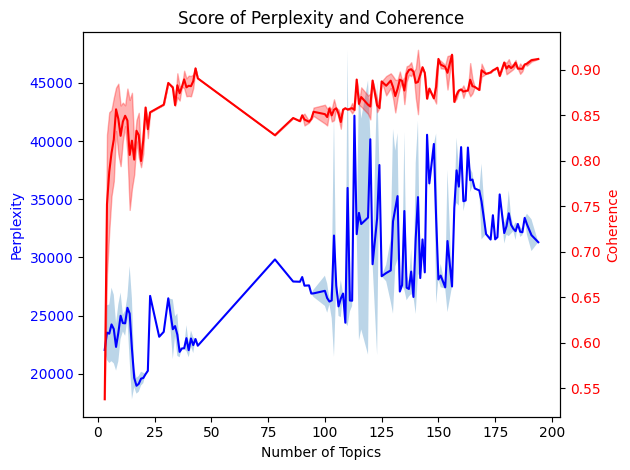

In [9]:
hdp_res = pd.read_csv("data/hdp_hp_opt_v2.csv")
plot_hdp_res(hdp_res)

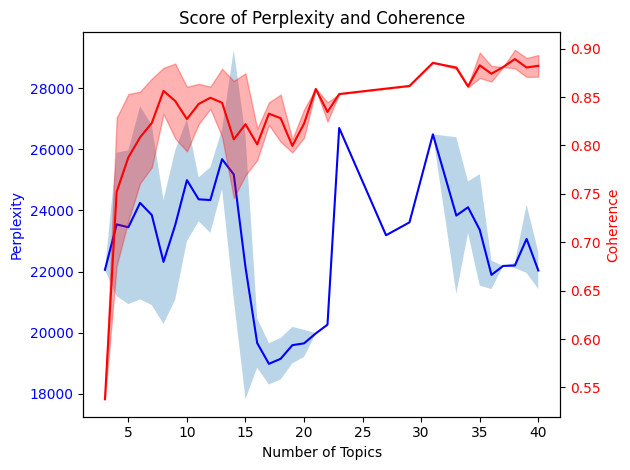

In [11]:
plot_hdp_res(hdp_res[hdp_res["num_topics"] <= 40])

Ive run the HDP model for different parameters, and those plots show the different number of topics that the model infer, with their corresponding metrics.
The best number of topics is around 15-20 for our dataset.

### Selected topic model analysis

In [8]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import re

def generate_dominant_topic_df(model, corpus, original_texts=None, feature_names=None, model_type='nmf'):
    df_topic_sents_keywords = pd.DataFrame()

    if model_type == 'nmf':
        W = model.transform(corpus)
        for i, row in enumerate(W):
            sorted_row = sorted(enumerate(row), key=lambda x: x[1], reverse=True)
            for j, (topic_num, prop_topic) in enumerate(sorted_row):
                if j == 0:
                    topic_keywords = ", ".join([feature_names[word] for word in model.components_[topic_num].argsort()[:-11:-1]])
                    df_topic_sents_keywords = pd.concat(
                        [df_topic_sents_keywords,
                         pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])],
                        ignore_index=True)
                else:
                    break
    elif model_type == 'lda':
        for i, row_list in enumerate(model[corpus]):
            row = row_list[0] if model.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:
                    wp = model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    df_topic_sents_keywords = pd.concat(
                        [df_topic_sents_keywords,
                         pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])],
                        ignore_index=True)
                else:
                    break

    contents = pd.Series(original_texts)
    df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, contents], axis=1)
    df_topic_sents_keywords.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']
    df_topic_sents_keywords["book"] = df_by_book.reset_index()["book"]

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'book']
    return df_dominant_topic

def print_top_topics_by_percentage(model, df_dominant_topic, model_type, feature_names=None, num_words=15):
    topics_by_freq = df_dominant_topic.groupby("Dominant_Topic")["Document_No"].count().sort_values(
        ascending=False).to_frame()
    topics_by_freq["freq"] = topics_by_freq["Document_No"] / topics_by_freq["Document_No"].sum()
    topics_by_freq.reset_index(inplace=True)
    sorted_topics = topics_by_freq.sort_values(by="freq", ascending=False)["Dominant_Topic"].to_list()

    if model_type == 'nmf':
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
            topics.append((topic_idx, ", ".join(words)))
        
        topics = [topics[int(i)] for i in sorted_topics]
        cleaned_topics = [topic[1] for topic in topics]
    elif model_type == 'lda':
        topics = model.print_topics(num_topics=-1, num_words=num_words)
        topics = [topics[int(i)] for i in sorted_topics]
        cleaned_topics = []
        for topic_no, topic in topics:
            words = re.findall(r'"([^"]*)"', topic)
            cleaned_topics.append(', '.join(sorted(words)))

    print(f"{model_type.upper()} num_topics={len(sorted_topics)}, sorted by % from all docs")
    for i, topic in zip(sorted_topics, cleaned_topics):
        doc_n = topics_by_freq[(topics_by_freq["Dominant_Topic"] == i)]["Document_No"].values[0]
        doc_ratio = topics_by_freq[(topics_by_freq["Dominant_Topic"] == i)]["freq"].values[0]
        print(f"Topic {i} ({doc_n} docs, {doc_ratio:.2%} from all docs): {topic}")

# Assuming `texts` is your preprocessed text data and `df_by_book` is your original dataframe
texts = generate_components(df_by_book, "text", min_count_bigram=1, threshold_bigram=4, top_words_removal=8, bottom_words_removal=10, words_removal=True, bigram_process=False)

# NMF model
original_texts = [' '.join(text) for text in texts]
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(original_texts)
feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_model = NMF(n_components=10, init='random', random_state=0, max_iter=4500)
nmf_model.fit(tfidf)
df_dominant_topic_nmf = generate_dominant_topic_df(nmf_model, tfidf, original_texts, feature_names, model_type='nmf')
print("NMF results")
print_top_topics_by_percentage(nmf_model, df_dominant_topic_nmf, 'nmf', feature_names, num_words=15)

# LDA model
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=0, update_every=1, passes=10, alpha='auto', per_word_topics=True)
df_dominant_topic_lda = generate_dominant_topic_df(lda_model, corpus, original_texts, model_type='lda')
print("LDA results")
print_top_topics_by_percentage(lda_model, df_dominant_topic_lda, 'lda', num_words=15)


texts = generate_components(df_by_book, "text_lex", min_count_bigram=1, threshold_bigram=4, top_words_removal=8, bottom_words_removal=10, words_removal=True, bigram_process=False)
# NMF model
original_texts = [' '.join(text) for text in texts]
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(original_texts)
feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_model = NMF(n_components=10, init='random', random_state=0, max_iter=4500)
nmf_model.fit(tfidf)
df_dominant_topic_nmf = generate_dominant_topic_df(nmf_model, tfidf, original_texts, feature_names, model_type='nmf')
print("NMF results")
print_top_topics_by_percentage(nmf_model, df_dominant_topic_nmf, 'nmf', feature_names, num_words=15)

# LDA model
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=0, update_every=1, passes=10, alpha='auto', per_word_topics=True)
df_dominant_topic_lda = generate_dominant_topic_df(lda_model, corpus, original_texts, model_type='lda')
print("LDA results")
print_top_topics_by_percentage(lda_model, df_dominant_topic_lda, 'lda', num_words=15)


Removed most_common_words=['את', 'יהוה', '', 'אשר', 'אל', 'על', 'כי', 'כול'], least_common_words=['ויוצאך', 'הוציאתך', 'היטבו', 'ומתתנו', 'חמצ', 'ומקנת', 'יבלה', 'ושרתם', 'ויורה', 'ובשערך'] from text
NMF results
NMF num_topics=10, sorted by % from all docs
Topic 8 (39 docs, 19.31% from all docs): לא, כל, צבאות, ולא, אמר, נאם, ישראל, אדני, כה, אני, ביום, בית, ויאמר, יהודה, הארץ
Topic 9 (32 docs, 15.84% from all docs): כיא, לוא, עולם, בכול, לאין, עם, נהיה, לכול, אתה, לכה, אמן, וכול, ברוך, ואתה, ואין
Topic 0 (27 docs, 13.37% from all docs): משה, פרעה, ואת, ישראל, בני, ויאמר, כל, מצרים, אהרן, לא, העם, לכם, לאמר, ליהוה, יוסף
Topic 6 (26 docs, 12.87% from all docs): כיא, לוא, פשרו, ולוא, הואה, ישראל, אמר, ויואמר, המה, פשר, מושה, יעקוב, כתוב, ואת, היאה
Topic 1 (23 docs, 11.39% from all docs): אלהיך, לא, לך, כל, ולא, אנכי, היום, נתן, והיה, הארץ, אלהיכם, פן, מצוך, יהיה, בך
Topic 3 (20 docs, 9.90% from all docs): די, מלכא, מן, ארעא, לה, אנה, שמיא, דן, להון, באדין, לא, אנון, ואמר, חד, רבא
Topic 2

In [22]:
df_by_book = pd.read_csv('data/full_data_nonbib_01_05_24.csv')
df_by_book = pd.merge(df_dominant_topic_tp[["Dominant_Topic", "book"]], df_by_book, on="book")
df_by_book = pd.merge(
    df_dominant_topic_tp_lem[["Dominant_Topic", "book"]].rename(columns={"Dominant_Topic": "Dominant_Topic_lem"}),
    df_by_book, on="book")

In [40]:
from collections import Counter
import warnings
import matplotlib.colors as mcolors


def generate_word_dist_plot(model, texts, model_type, num_words_per_topic, biggest_topics, topics_to_show, title):
    warnings.filterwarnings("ignore")
    if model_type == "gensim":
        topics = model.show_topics(num_topics=-1, formatted=False, num_words=num_words_per_topic)
    if model_type == "tomotopy":
        topics = [model.get_topic_words(k_topic, top_n=num_words_per_topic) for k_topic in range(model_tp.k)]
        topics = enumerate(topics)
    data_flat = [w for w_list in texts for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(topics_to_show // 2, 2, figsize=(15, 10), sharey=True)
    cols = [color for name, color in mcolors.XKCD_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == biggest_topics[i], :], color=cols[i],
               width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == biggest_topics[i], :], color=cols[i],
                    width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(biggest_topics[i]), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels([w[::-1] for w in df.loc[df.topic_id == biggest_topics[i], 'word']], rotation=30,
                           horizontalalignment='right')  #reverse heb
        ax.tick_params(axis='x', labelrotation=45)
        ax.legend(loc='upper left');
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()
    warnings.filterwarnings("default")



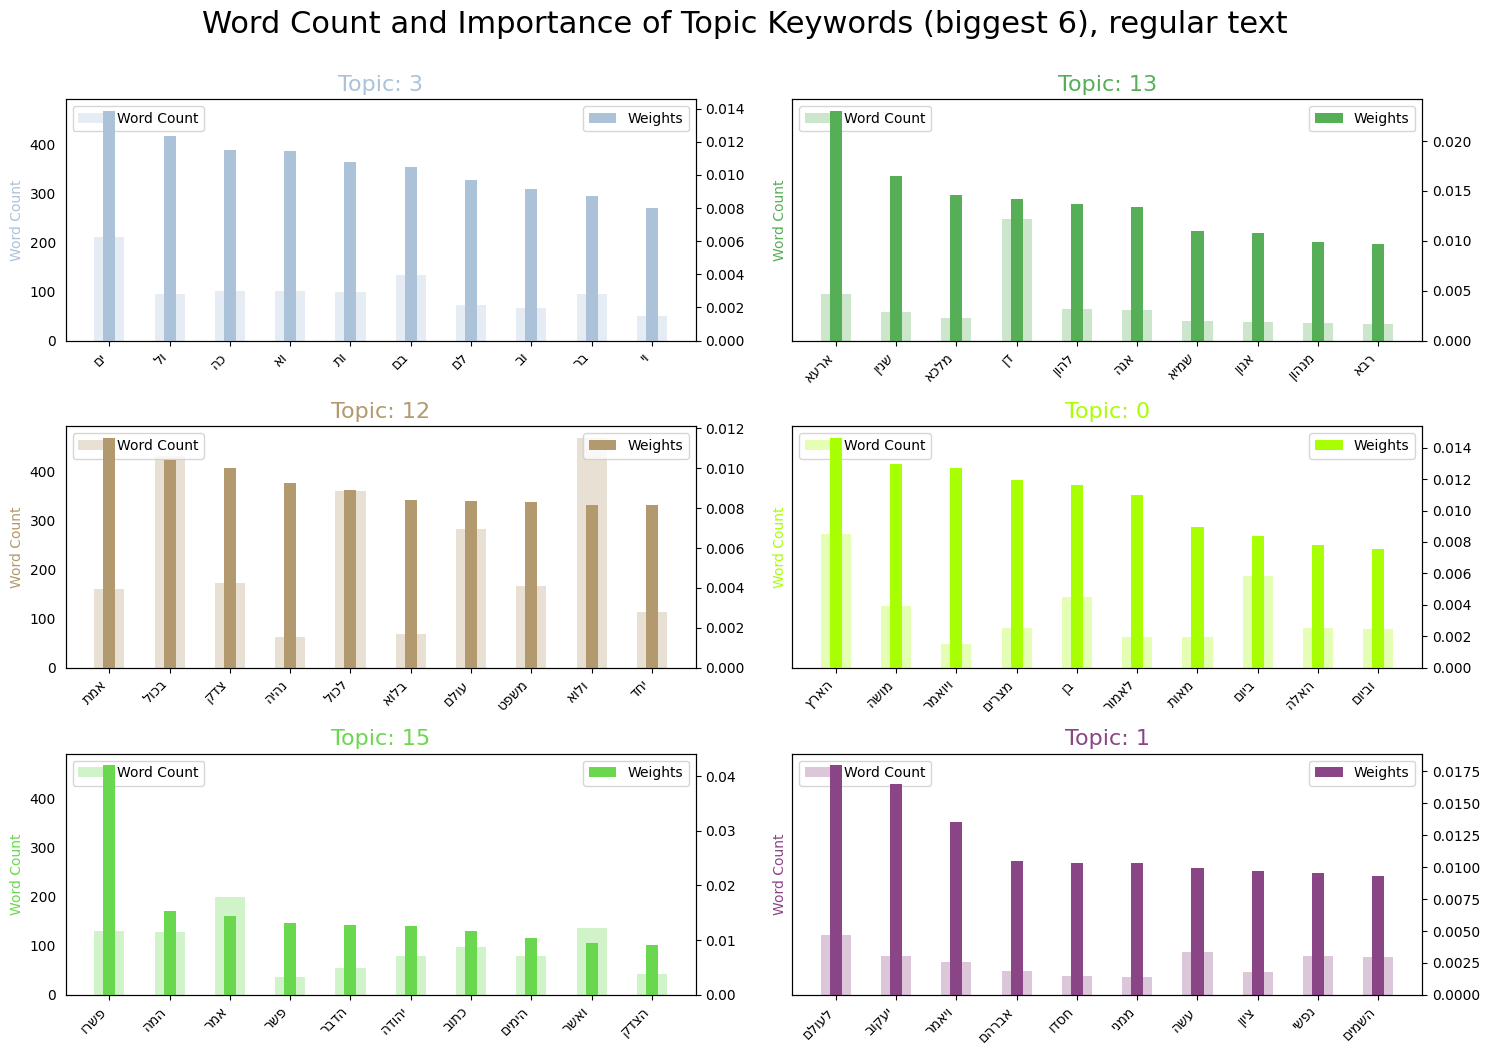

In [43]:
topics_to_show = 6
biggest_topics = df_dominant_topic_tp.groupby("Dominant_Topic")["Document_No"].count().sort_values(ascending=False)[
                 :topics_to_show].index.to_list()
generate_word_dist_plot(model_tp, texts, "tomotopy", 10, biggest_topics, topics_to_show,
                        f'Word Count and Importance of Topic Keywords (biggest {topics_to_show}), regular text')

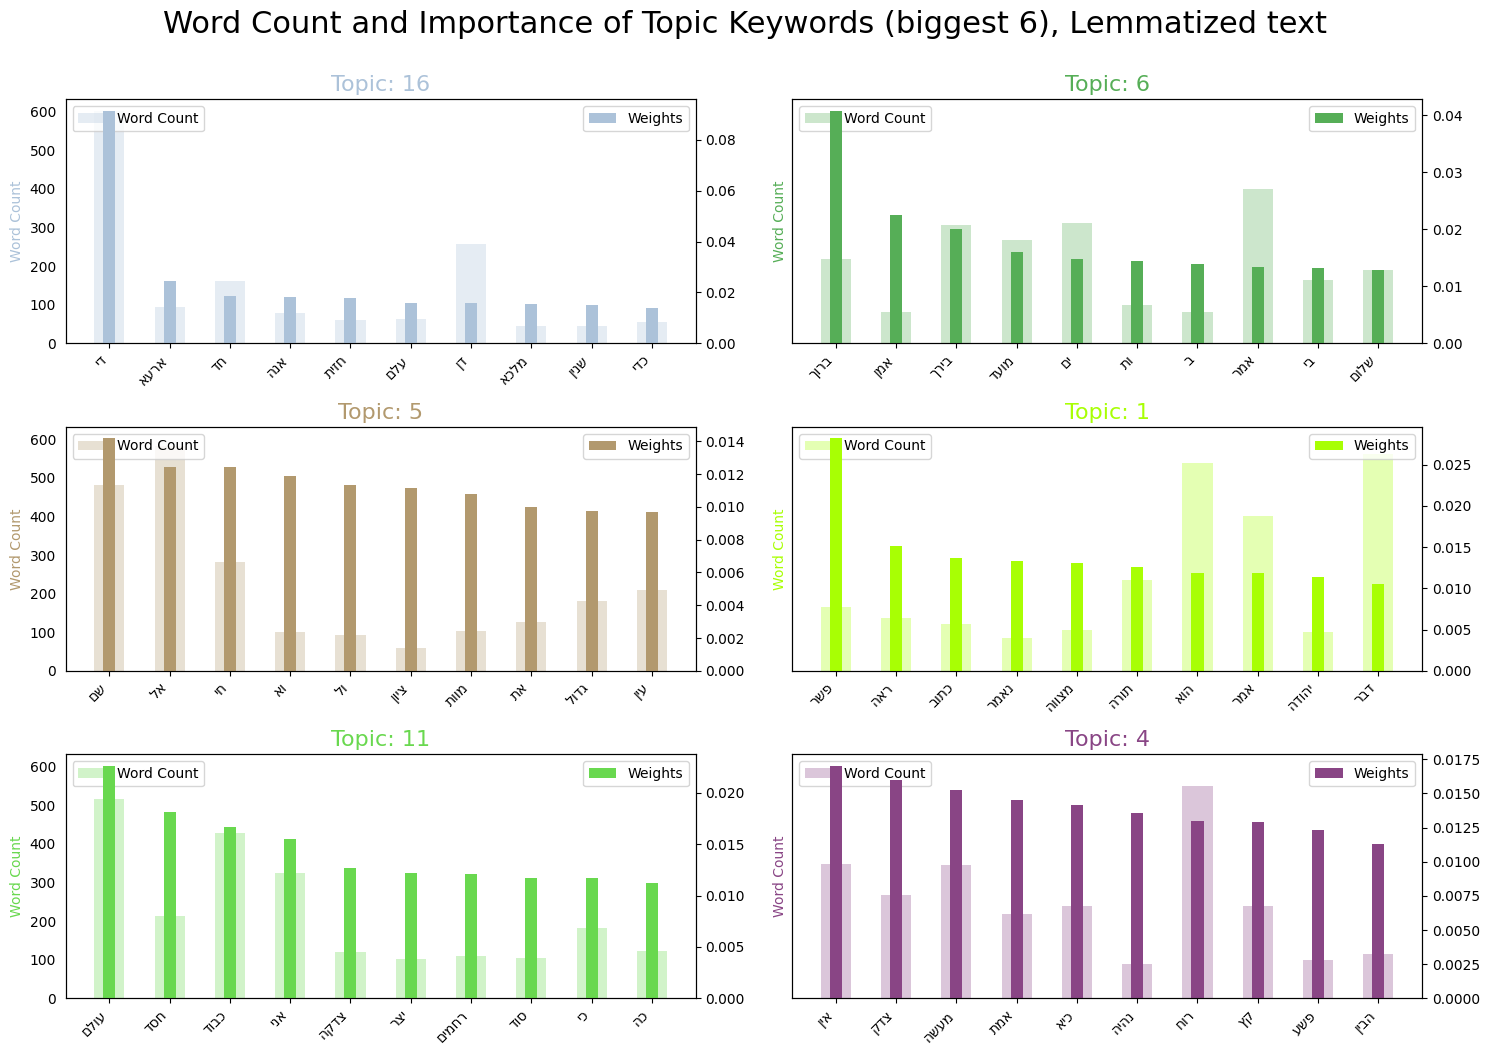

In [44]:
biggest_topics = df_dominant_topic_tp_lem.groupby("Dominant_Topic")["Document_No"].count().sort_values(ascending=False)[
                 :topics_to_show].index.to_list()
generate_word_dist_plot(model_tp_lem, texts_lem, "tomotopy", 10, biggest_topics, topics_to_show,
                        f'Word Count and Importance of Topic Keywords (biggest {topics_to_show}), Lemmatized text')

In [45]:
df_by_book.to_csv("data/full_data_nonbib_01_05_24_with_topics.csv", index=False)

### Appendinx - Type of coherence measures
Coherence measures in topic modeling are crucial for evaluating the quality of the topics extracted by models such as LDA. They help determine how meaningful and interpretable the topics are. I will give a short overview of four common types of coherence measures: `u_mass`, `c_v`, `c_uci`, and `c_npmi`, including their formulas and whether higher or lower values are better.

[Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324)

1. UCI is the first coherence measure developed by Newman et al. (2010). This measure calculates the coherence by using the top $N$ words from each topic. The UCI coherence is defined as follows:

$$
\text{UCI} = \frac{2}{N \cdot (N-1)} \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} \text{PMI}(w_i, w_j)
$$

Where:
- $N$ is the number of top words chosen for each topic.
- PMI($w_i, w_j$) represents the pointwise mutual information between words $ w_i $ and $ w_j $, calculated as:
  $$
  \text{PMI}(w_i, w_j) = \log \frac{P(w_i, w_j) + \epsilon}{P(w_i) \cdot P(w_j)}
  $$

- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring within a certain sliding window through the corpus.
- $ P(w_i) $ and $ P(w_j) $ are the probabilities of observing each word independently as the window slides through the corpus.
- $ \epsilon $ is a smoothing factor added to avoid taking a logarithm of zero. The original UCI measure sets $ \epsilon = 1 $.

UCI is essentially the average PMI of the top $ N $ words in each topic. As words co-occur more frequently within the specified context window, their PMI, and thus the UCI score, increases. This measure evaluates how semantically coherent the top words in a topic are, based on their co-occurrence in an external corpus.


2. UMass, developed by Mimno et al. (2011), computes the co-occurrence between pairs of words using only the model's training documents, unlike UCI which uses an external corpus. The UMass coherence measure is defined as follows:

$$
\text{UMass} = \frac{2}{N \cdot (N-1)} \sum_{i=1}^{N} \sum_{j=1}^{i-1} \log \frac{P(w_i, w_j) + \epsilon}{P(w_j)}
$$

Where:
- $ N $ is the number of top words selected from each topic.
- $ P(w_j) $ is the probability of observing word $ w_j $, calculated by counting how many documents contain the word $ w_j $.
- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring in the same documents, based on the count of documents that contain both words.
- $ \epsilon $ is a smoothing factor added to avoid taking a logarithm of zero, typically set to 1 in the original formulation.

While the formulas for UCI and UMass might look similar, their calculations differ significantly. UMass specifically looks for co-occurrence within the documents of the training corpus, focusing on document co-occurrence rather than sliding window co-occurrence. This measure calculates the average logarithmic document co-occurrence for each topic, and an increase in co-occurrence leads to a higher UMass score.

3. NPMI (Normalized Pointwise Mutual Information), introduced by Aletras and Stevenson (2013), modifies the traditional PMI (Pointwise Mutual Information) used in coherence measures like UCI by normalizing it. The normalization of PMI helps rescale the probabilities of word co-occurrence, which is defined as follows:

$$
\text{NPMI}(w_i, w_j) = \frac{\log \frac{P(w_i, w_j) + \epsilon}{P(w_i) \cdot P(w_j)}}{-\log (P(w_i, w_j) + \epsilon)}
$$

Where:
- $ P(w_i, w_j) $ is the probability of observing words $ w_i $ and $ w_j $ co-occurring within a specified context.
- $ P(w_i) $ and $ P(w_j) $ are the probabilities of observing each word independently.
- $ \epsilon $ is a smoothing factor, typically added to ensure the logarithm is not computed for zero.

This measure applies a negative logarithm to the co-occurrence probability of each word pair to normalize the results, making NPMI a ratio that ranges from -1 to 1. Studies such as those by Aletras and Stevenson (2013) and later by Lau et al. (2014) found that NPMI performed better and correlated more closely with human judgment compared to UCI. In practice, NPMI scores for all top word pairs in a topic are averaged to produce the final coherence score for that topic.

4. C_V Coherence Measure

Developed by Röder et al. (2015), the C_V coherence measure emerges from a comprehensive framework designed to enhance coherence calculations. This framework led to the development of several new coherence measures, with C_V being particularly noteworthy for its high correlation with human evaluations.

Unlike traditional coherence measures that rely on co-occurrence frequencies, C_V uses context vectors. These vectors count the occurrences of words within a window of ± five tokens from each top word but restricts this count to the topic's top words. This ensures that all vectors are uniform in length and composition.

For instance, if the top words in a topic are "game, sport, team," the context vector for "game" would be computed as follows:
$$
\vec{v}_{\text{game}} = [\text{NPMI}(\text{game, game}), \text{NPMI}(\text{game, sport}), \text{NPMI}(\text{game, team})]
$$

After constructing the context vectors, C_V computes the cosine similarity between them to gauge coherence:
$$
\text{cos}(\vec{u}, \vec{w}) = \frac{\sum_{i=1}^{|W|} u_i \cdot w_i}{\|\vec{u}\|^2 \cdot \|\vec{w}\|^2}
$$
where $ \vec{u} $ and $ \vec{w} $ are the context vectors being compared, and $ W $ represents all top word context vectors.

The key innovation of C_V is its focus on indirect semantic similarities rather than direct co-occurrences, allowing it to capture semantic relationships that are not evident through simple co-occurrence.


In the article [Exploring the Space of Topic Coherence Measures](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) the researchers showed that the CV method is mostly correlated with human judgments.




<!---
mostly taken from https://fse.studenttheses.ub.rug.nl/28618/1/s2863685_alfiuddin_hadiat_CCS_thesis.pdf
-->